In [1]:
import dask
import physt
import numpy as np

import dask.array as da

In [47]:
def dask_adaptive(a, bin_width, **kwargs):
    import dask
    name = "dask_adaptive"
    def block_hist(array):
        return physt.h1(array, "fixed_width", bin_width=bin_width, adaptive=True, **kwargs)
  
    dsk = dict(((name, i, 0), (block_hist, k))
                    for i, k in enumerate(dask.core.flatten(a._keys())))
    dsk.update(a.dask)   
    start = physt.h1(None, "fixed_width", bin_width=bin_width, adaptive=True, **kwargs)
    for h in dsk:
        h_ = dask.get(dsk, h)
        if h[0] == "dask_adaptive":
            start += dask.get(dsk, h)
    return start

In [20]:
%matplotlib inline

In [21]:
million = np.random.rand(10000000)

In [61]:
chunked = da.from_array(million, chunks=(100000))

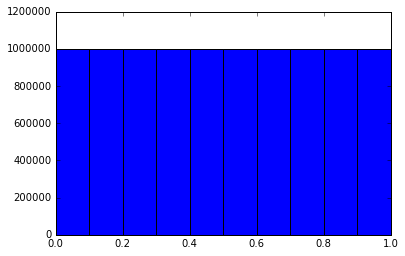

In [50]:
h.plot()

In [62]:
%time hz = physt.h1(million, "fixed_width", 0.1)

CPU times: user 2.31 s, sys: 118 ms, total: 2.43 s
Wall time: 2.43 s


In [63]:
%time hy = dask_adaptive(chunked, 0.1)

() None
CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.83 s


In [ ]:
%time hy = physt.h1(million)

In [ ]:
%time chunked.min().compute()

In [ ]:
%time chunked.max().compute()

In [ ]:
%time da.percentile(chunked, [0, 100]).compute()

In [ ]:
chunked.min().compute()

In [ ]:
%time da.percentile(chunked, [1, 100]).compute()

In [ ]:
%time da.percentile(chunked, 100).compute()